In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from pyproj import Geod
from matplotlib.animation import FuncAnimation, PillowWriter

In [2]:
df = pd.read_json('../data/car_log_20250504_132551_small_track_gt.jsonl', lines=True)
df.head(10)

,timestamp,speed_mps,yaw,steering_angle,latitude,longitude,altitude
0,63798,1.699987,0.0,0.0,55.944493,-3.186458,0.652514
1,63998,1.699987,0.0,0.0,55.944493,-3.186453,0.652514
2,64198,1.699987,0.0,0.0,55.944493,-3.186448,0.652513
3,64398,1.699987,0.0,0.0,55.944493,-3.186442,0.652513
4,64598,1.699987,0.0,0.0,55.944493,-3.186437,0.652512
5,64798,1.699987,0.0,0.0,55.944493,-3.186431,0.652512
6,64998,1.699987,0.0,0.0,55.944493,-3.186426,0.652511
7,65198,1.699987,0.0,0.0,55.944493,-3.186420,0.652511
8,65398,1.699987,0.0,0.0,55.944493,-3.186415,0.652510
9,65598,1.699987,0.0,0.0,55.944493,-3.186409,0.652510


In [3]:
df.shape

(303, 7)

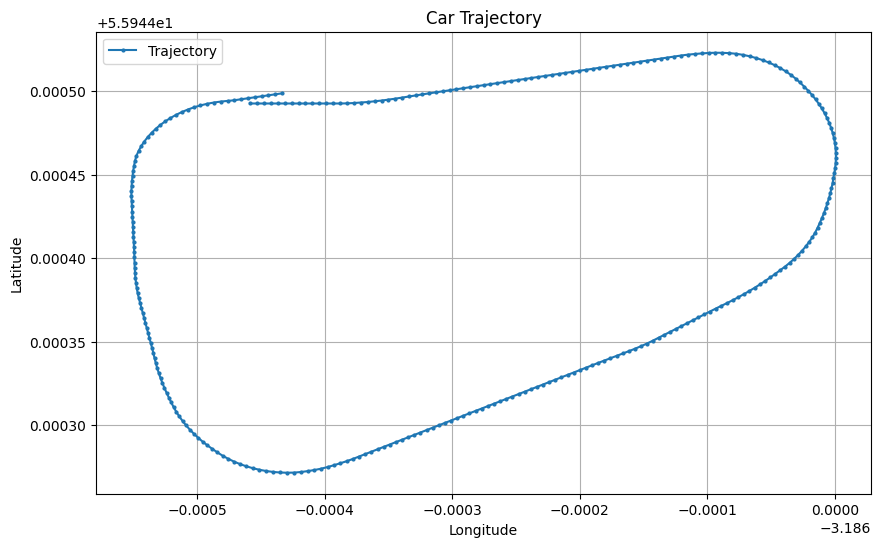

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(df['longitude'], df['latitude'], marker='o', markersize=2, linestyle='-', label='Trajectory')
plt.title('Car Trajectory')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.show()

In [5]:
waypoint_gap = 10  # Define the gap between waypoints
num_waypoints = 9

In [6]:
# Remove the last 6 entries
df = df.iloc[:-6]

# Calculate the number of entries to add
entries_to_add = waypoint_gap * (num_waypoints + 1)

first_entries = df.iloc[:entries_to_add]

# Add the selected entries to the end of the DataFrame
df = pd.concat([df, first_entries], ignore_index=True)

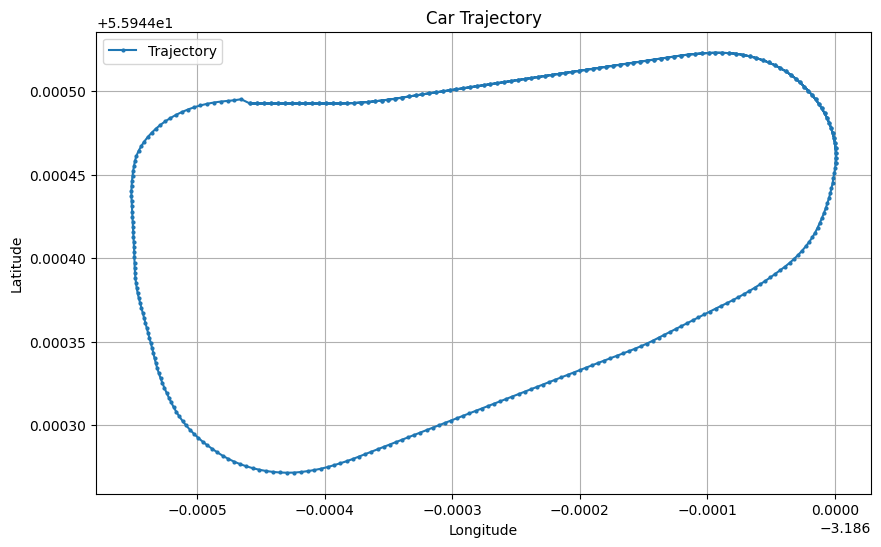

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(df['longitude'], df['latitude'], marker='o', markersize=2, linestyle='-', label='Trajectory')
plt.title('Car Trajectory')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.show()

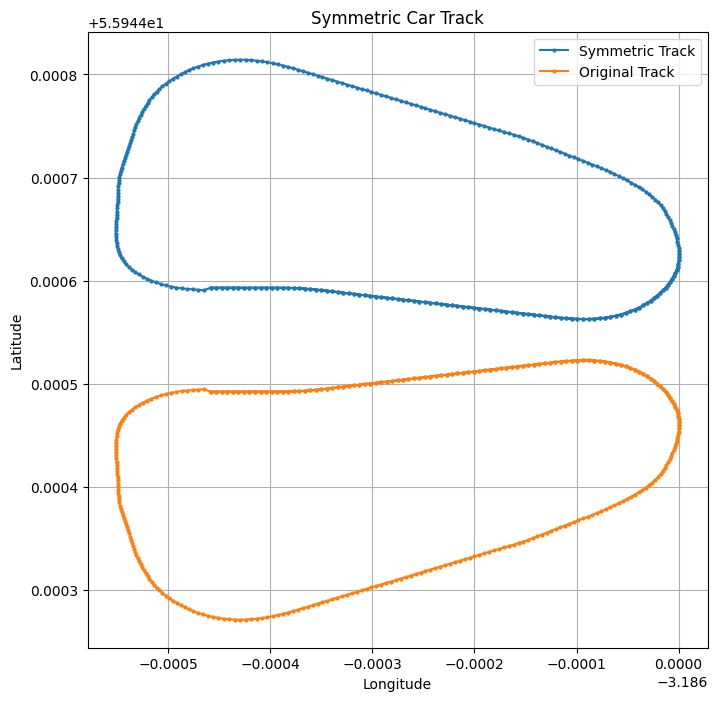

In [8]:
# Create a symmetric track by mirroring the trajectory along (max latitude + a gap)
lat_gap = 0.00002  # Define a small gap
mirror_lat = df['latitude'].max() + lat_gap
df_symmetric = df.copy()
df_symmetric['latitude'] = 2 * mirror_lat - df['latitude']
df_symmetric['steering_angle'] = df_symmetric['steering_angle'] * -1

# Plot the symmetric track
plt.figure(figsize=(8, 8))
plt.plot(df_symmetric['longitude'], df_symmetric['latitude'], marker='o', markersize=2, linestyle='-', label='Symmetric Track')
plt.plot(df['longitude'], df['latitude'], marker='o', markersize=2, linestyle='-', label='Original Track')
plt.title('Symmetric Car Track')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.show()

In [10]:
# Initialize Geod object for coordinate transformations
geod = Geod(ellps="WGS84")

# Function to calculate local coordinates (x, y) from global coordinates
def calculate_local_coordinates(lat, lon, waypoints):
    local_coords = []
    for wp_lat, wp_lon in waypoints:
        azimuth, _, distance = geod.inv(lon, lat, wp_lon, wp_lat)
        x = distance * np.cos(np.radians(azimuth))
        y = distance * np.sin(np.radians(azimuth))
        local_coords.append((x, y))
    return local_coords

# Create the dataset
def create_training_data(df_input, waypoint_gap, num_waypoints):
    dataset = []
    for i in range(len(df_input) - waypoint_gap * (num_waypoints + 1)):
        for j in range(waypoint_gap-1, -1, -1):
            current_row = df_input.iloc[i]
            waypoint_start = i + waypoint_gap + waypoint_gap//2 - j
            waypoint_end = waypoint_start + waypoint_gap * num_waypoints
            waypoint_indices = range(waypoint_start, waypoint_end, waypoint_gap)
            waypoints = df_input.iloc[list(waypoint_indices)][["latitude", "longitude"]].values
            local_coords = calculate_local_coordinates(current_row["latitude"], current_row["longitude"], waypoints)
            dataset.append({
                "current_latitude": current_row["latitude"],
                "current_longitude": current_row["longitude"],
                "steering_angle": current_row["steering_angle"],
                "waypoints": local_coords,
            })
    return pd.DataFrame(dataset)

# Create training data for both original and symmetric tracks and concatenate
training_data = pd.concat([
    create_training_data(df, waypoint_gap, num_waypoints),
    create_training_data(df_symmetric, waypoint_gap, num_waypoints)
], ignore_index=True)

print(f"Training data shape: {training_data.shape}")
training_data.head()

Training data shape: (5940, 4)


,current_latitude,current_longitude,steering_angle,waypoints
0,55.944493,-3.186458,0.0,"[(4.970429980219282e-06, 2.0399844362863626), ..."
1,55.944493,-3.186458,0.0,"[(5.7990210948584615e-06, 2.3799818418658663),..."
2,55.944493,-3.186458,0.0,"[(6.627014185430922e-06, 2.719979247810596), (..."
3,55.944493,-3.186458,0.0,"[(7.454409252155283e-06, 3.059976653838466), (..."
4,55.944493,-3.186458,0.0,"[(8.26240308976906e-06, 3.3999743200838184), (..."


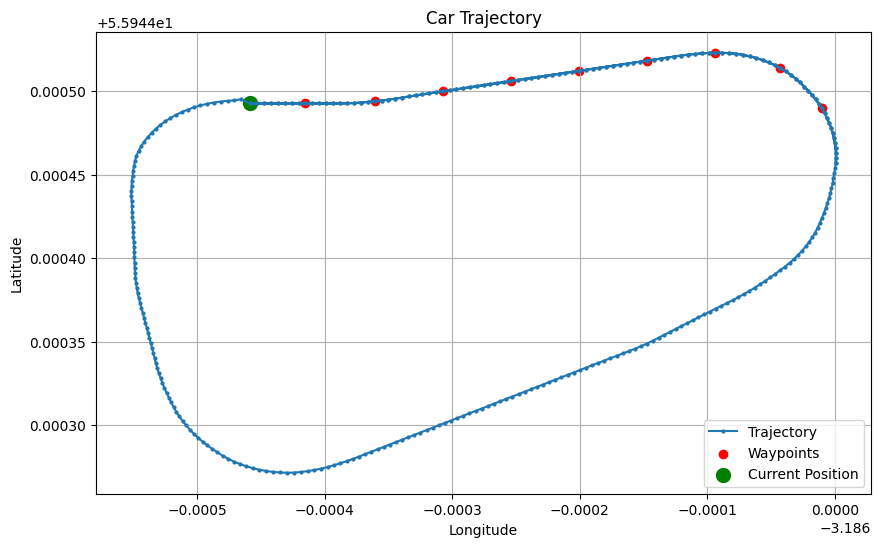

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(df['longitude'], df['latitude'], marker='o', markersize=2, linestyle='-', label='Trajectory')
plt.title('Car Trajectory')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()

# Add one training_data entry to the plot
entry = training_data.iloc[2]  # Select an entry from the dataset
local_coords = np.array(entry['waypoints'])

# Convert local coordinates back to global for plotting
global_coords = []
for x, y in local_coords:
    lon, lat, _ = geod.fwd(entry['current_longitude'], entry['current_latitude'], np.degrees(np.arctan2(y, x)), np.hypot(x, y))
    global_coords.append((lat, lon))

plot_waypoints = np.array(global_coords)

# Plot the waypoints
plt.scatter(plot_waypoints[:, 1], plot_waypoints[:, 0], color='red', label='Waypoints')

# Add the current position
plt.scatter(entry['current_longitude'], entry['current_latitude'], color='green', label='Current Position', s=100)

plt.legend()
plt.show()

In [12]:
# Initialize the figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df['longitude'], df['latitude'], marker='o', markersize=2, linestyle='-', label='Trajectory')
ax.set_title('Car Trajectory with Waypoints')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid()
trajectory_line, = ax.plot([], [], 'ro-', label='Waypoints')  # Line for waypoints
current_position, = ax.plot([], [], 'go', label='Current Position', markersize=10)  # Current position marker
ax.legend()

# Function to update the plot for each frame
def update(frame):
    entry = training_data.iloc[frame]
    local_coords = np.array(entry['waypoints'])

    # Convert local coordinates back to global for plotting
    global_coords = []
    for x, y in local_coords:
        lon, lat, _ = geod.fwd(entry['current_longitude'], entry['current_latitude'], np.degrees(np.arctan2(y, x)), np.hypot(x, y))
        global_coords.append((lat, lon))

    plot_waypoints = np.array(global_coords)

    # Update the trajectory line and current position
    trajectory_line.set_data(plot_waypoints[:, 1], plot_waypoints[:, 0])
    current_position.set_data([entry['current_longitude']], [entry['current_latitude']])
    return trajectory_line, current_position

# Create the animation
num_frames = waypoint_gap*3
ani = FuncAnimation(fig, update, frames=num_frames, interval=100, blit=True)

# Save the animation as a GIF
gif_path = './imgs/car_trajectory.gif'
ani.save(gif_path, writer=PillowWriter(fps=10))
plt.close(fig)

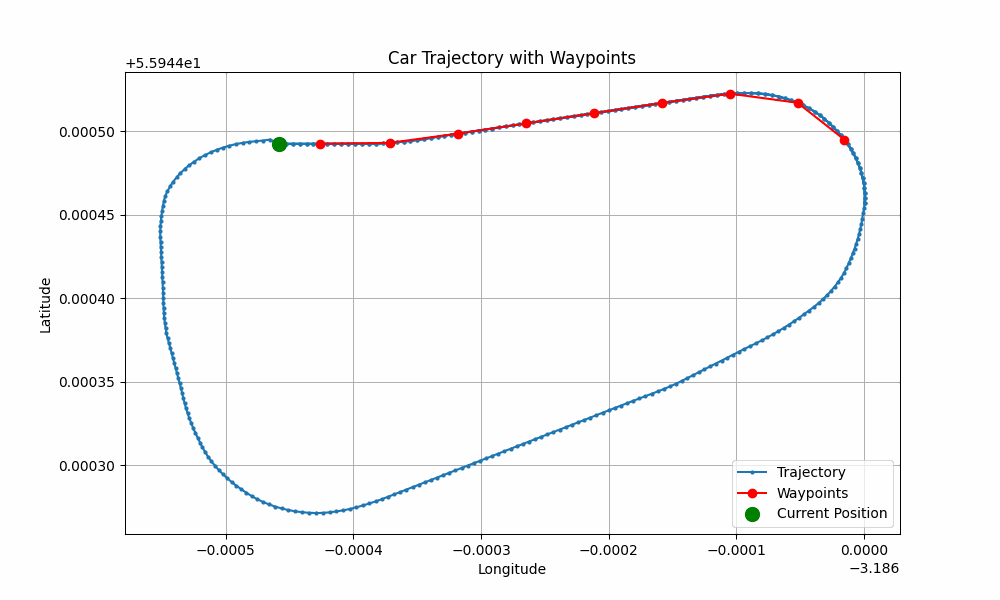

In [13]:
Image(filename=gif_path)

In [14]:
# Initialize the figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_symmetric['longitude'], df_symmetric['latitude'], marker='o', markersize=2, linestyle='-', label='Trajectory')
ax.set_title('Car Trajectory with Waypoints')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid()
trajectory_line, = ax.plot([], [], 'ro-', label='Waypoints')  # Line for waypoints
current_position, = ax.plot([], [], 'go', label='Current Position', markersize=10)  # Current position marker
ax.legend()

# Function to update the plot for each frame
def update(frame):
    entry = training_data.iloc[frame % len(training_data)]  # Wrap around using modulo
    local_coords = np.array(entry['waypoints'])

    # Convert local coordinates back to global for plotting
    global_coords = []
    for x, y in local_coords:
        lon, lat, _ = geod.fwd(entry['current_longitude'], entry['current_latitude'], np.degrees(np.arctan2(y, x)), np.hypot(x, y))
        global_coords.append((lat, lon))

    plot_waypoints = np.array(global_coords)

    # Update the trajectory line and current position
    trajectory_line.set_data(plot_waypoints[:, 1], plot_waypoints[:, 0])
    current_position.set_data([entry['current_longitude']], [entry['current_latitude']])
    return trajectory_line, current_position

# Update the number of frames to show the last entries with wrapping
num_frames = len(training_data) - waypoint_gap * 10
ani = FuncAnimation(fig, update, frames=range(num_frames, len(training_data)), interval=100, blit=True)

# Save the updated animation as a GIF
gif_path = './imgs/car_trajectory_last_entries_wrapped.gif'
ani.save(gif_path, writer=PillowWriter(fps=10))
plt.close(fig)

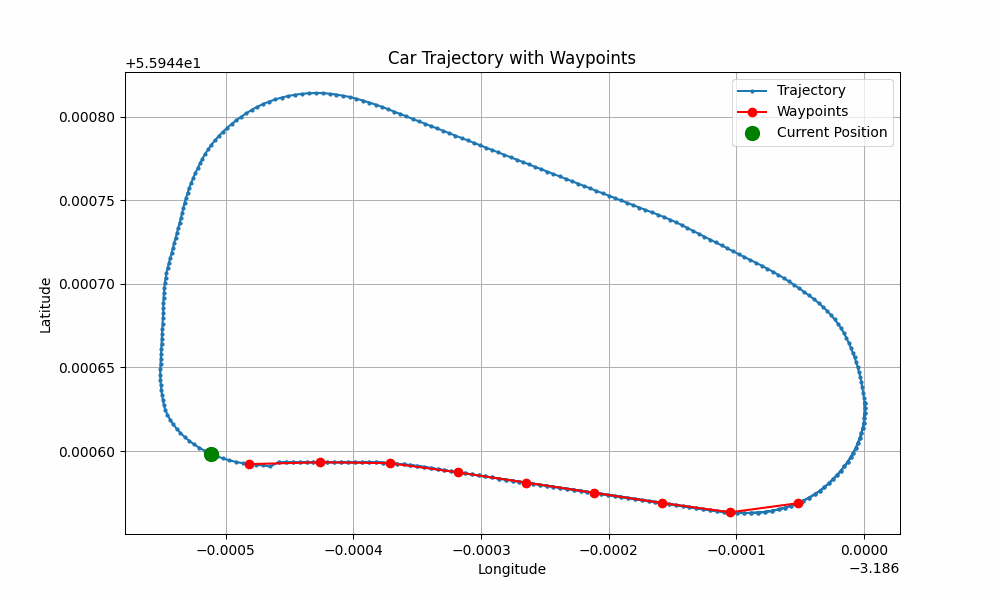

In [15]:
Image(filename=gif_path)

In [16]:
training_data.shape

(5940, 4)

In [17]:
# Expand waypoints into individual columns
max_waypoints = len(training_data['waypoints'].iloc[0])  # Determine the maximum number of waypoints
for i in range(max_waypoints):
    training_data[f'waypoint{i+1}_lat'] = training_data['waypoints'].apply(lambda x: x[i][0])
    training_data[f'waypoint{i+1}_lon'] = training_data['waypoints'].apply(lambda x: x[i][1])

# Drop the original waypoints column if no longer needed
training_data_cleaned = training_data.drop(columns=['waypoints', 'current_latitude', 'current_longitude'])

# Display the updated DataFrame
training_data_cleaned.head()

,steering_angle,waypoint1_lat,waypoint1_lon,waypoint2_lat,waypoint2_lon,waypoint3_lat,waypoint3_lon,waypoint4_lat,waypoint4_lon,waypoint5_lat,waypoint5_lon,waypoint6_lat,waypoint6_lon,waypoint7_lat,waypoint7_lon,waypoint8_lat,waypoint8_lon,waypoint9_lat,waypoint9_lon
0,0.0,0.000005,2.039984,0.061428,5.437665,0.676868,8.779054,1.357823,12.110115,2.038817,15.441215,2.719791,18.772296,3.336578,22.113934,2.733626,25.397808,0.278554,27.688657
1,0.0,0.000006,2.379982,0.098773,5.775575,0.744948,9.112143,1.425921,12.443222,2.106914,15.774323,2.787870,19.105384,3.366775,22.452577,2.555943,25.687571,-0.021109,27.849252
2,0.0,0.000007,2.719979,0.143449,6.112618,0.813063,9.445270,1.494018,12.776327,2.175012,16.107431,2.855986,19.438512,3.383666,22.792072,2.359333,25.964874,-0.327515,27.996511
3,0.0,0.000007,3.059977,0.195413,6.448613,0.881161,9.778378,1.562109,13.109431,2.243109,16.440539,2.924084,19.771620,3.377104,23.131964,2.144726,26.228435,-0.640093,28.130171
4,0.0,0.000008,3.399974,0.254660,6.783423,0.949239,10.111467,1.630232,13.442567,2.311207,16.773647,2.992181,20.104728,3.355638,23.471221,1.913014,26.477145,-0.958220,28.249954


In [18]:
training_data_cleaned.to_csv('../data/datasets/training_data.csv', index=False)

In [19]:
# Add noisy entries to training_data_cleaned
noisy_data = training_data_cleaned.copy()
noise_std = 0.5  # Standard deviation for noise

# Add Gaussian noise to all waypoint latitude and longitude columns
for col in noisy_data.columns:
    if 'waypoint' in col:
        noisy_data[col] += np.random.normal(0, noise_std, size=noisy_data.shape[0])

# Concatenate the noisy data with the original
training_data_cleaned_noisy = pd.concat([training_data_cleaned, noisy_data], ignore_index=True)
training_data_cleaned_noisy.sample(5)

,steering_angle,waypoint1_lat,waypoint1_lon,waypoint2_lat,waypoint2_lon,waypoint3_lat,waypoint3_lon,waypoint4_lat,waypoint4_lon,waypoint5_lat,waypoint5_lon,waypoint6_lat,waypoint6_lon,waypoint7_lat,waypoint7_lon,waypoint8_lat,waypoint8_lon,waypoint9_lat,waypoint9_lon
8338,0.0,4.580705,-0.494014,7.883412,-1.407494,11.756006,-0.726868,15.506838,0.518486,16.490559,3.999587,14.875816,7.401677,16.237103,10.237843,17.055392,14.361755,18.117260,16.366691
5680,0.1,-2.006855,0.325201,-4.590450,2.437336,-5.163250,5.772873,-5.163251,9.172838,-5.417890,12.556279,-6.112452,15.884319,-6.793422,19.215417,-7.474369,22.546498,-8.155311,25.877580
1904,0.0,-1.381518,-3.095995,-1.133852,-6.420655,1.035916,-8.991190,4.093942,-10.434634,7.411414,-11.165711,10.753064,-11.788783,14.147897,-11.948607,17.545723,-12.039545,20.807980,-11.250991
2254,-0.2,3.242428,-1.003180,6.582080,-1.639662,9.951127,-2.042655,13.348949,-2.159650,16.738858,-2.020572,19.583743,-0.284995,20.767403,2.844018,20.550702,6.323953,20.694147,9.716592
5499,0.1,-5.096310,-0.183626,-8.462128,0.157545,-11.045723,2.269680,-11.618523,5.605217,-11.618524,9.005182,-11.873164,12.388623,-12.567726,15.716663,-13.248696,19.047761,-13.929643,22.378842


In [20]:
training_data_cleaned_noisy.to_csv('../data/datasets/training_data_noisy.csv', index=False)

# Generar el ground truth

In [21]:
waypoints_df = pd.DataFrame({
    'Longitude': df['longitude'][::waypoint_gap],
    'Latitude': df['latitude'][::waypoint_gap]
})

waypoints_df = waypoints_df.iloc[:-(waypoint_gap)]
waypoints_df = pd.concat([waypoints_df, waypoints_df.iloc[:1]], ignore_index=True)
waypoints_df.sample(5)

,Longitude,Latitude
7,-3.186083,55.944523
0,-3.186458,55.944493
8,-3.186035,55.944510
5,-3.186190,55.944513
25,-3.186547,55.944382


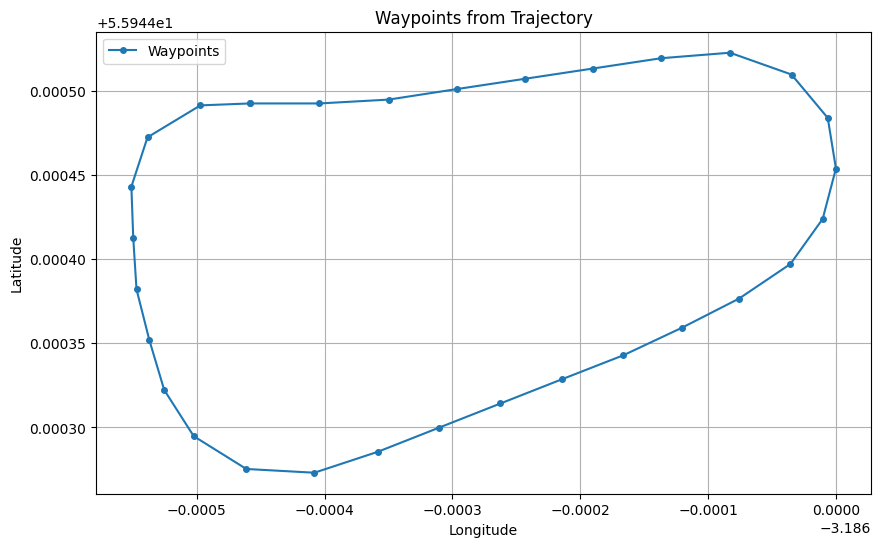

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(waypoints_df['Longitude'], waypoints_df['Latitude'], marker='o', markersize=4, linestyle='-', label='Waypoints')
plt.title('Waypoints from Trajectory')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.show()

In [23]:
waypoints_df.to_csv('../data/datasets/waypoints.csv', index=False)